# Selecting EIS Lines

This notebook produces a table of selected EIS lines and the associated fitting templates. It pulls the selection of lines from Warren et al. (2011).

In [8]:
import pathlib

import astropy.io
import astropy.table
import astropy.units as u
import eispac
import fiasco
import numpy as np
import plasmapy

In [9]:
intensities_warren = astropy.io.ascii.read('../data/tables/warren_2011_intensities.txt', format='mrt')
intensities_warren = intensities_warren[intensities_warren['Inst']=='EIS']
line_list = astropy.table.unique(intensities_warren[['ID']])

In [10]:
all_templates = [eispac.read_template(f) for f in eispac.data.fit_template_filenames()]

In [11]:
line_table_data = {
    'Element': [],
    'Z': [],
    'Ion': [],
    'Name': [],
    'Wavelength': [],
    'Template': [],
}
temperature_array = np.logspace(5,8,5000) * u.K
for line in line_list['ID']:
    el,ion,wave = line.lower().split()
    #Z,ion = fiasco.util.parse_ion_name((el,ion))
    _ion = fiasco.Ion((el,ion), temperature_array)
    #tname = f'{f"{el}_" if len(el)==1 else el}_{ion:02d}_{"_".join(wave.split("."))}'
    #tname_files = [f.name for f in template_filenames if tname in f.name]
    tname = f'{_ion.ion_name_roman} {wave}'
    templates = [t for t in all_templates if tname in t.template['line_ids']]
    line_table_data['Ion'] += len(templates)*[_ion.ionization_stage]
    line_table_data['Wavelength'] += len(templates)*[float(wave)]
    line_table_data['Element'] += len(templates)*[_ion.atomic_symbol]
    line_table_data['Z'] += len(templates)*[_ion.atomic_number]
    line_table_data['Name'] += len(templates)*[tname]
    line_table_data['Template'] += templates
selected_line_table = astropy.table.QTable(line_table_data)
selected_line_table['Wavelength'] = selected_line_table['Wavelength'] * u.AA
selected_line_table['Number Gaussians'] = list(map(lambda x: x.template['n_gauss'], selected_line_table['Template']))
#selected_line_table = selected_line_table[np.argsort(selected_line_table['Wavelength'])]
selected_line_table['Included lines'] = list(map(lambda x: ', '.join(x.template['line_ids']), 
                                                 selected_line_table['Template']))
selected_line_table['Template filename'] = list(map(lambda x: pathlib.Path(x.filename_temp).name, 
                                                    selected_line_table['Template']))
selected_line_table.remove_column('Template')

This block selects out only a single template filename for eacch line. The logic here is to:

1. Select the template file with a filename that corresponds to the ion in question (a given template can have multiple ions in it)
2. Select the template with the most Gaussians included. The logic here is that in an AR context, we are more likely to encounter blends as compared to flares where a single line may be more likely to dominate and so we want to account for them if possible.

In [12]:
grouped_table = selected_line_table.group_by('Name')
selected_rows = []
for g in grouped_table.groups:
    _name = f'{g[0]["Element"].lower():_<{2}}_{g[0]["Ion"]:02}'
    is_named_template = [_name in tn for tn in g['Template filename']]
    _g = g[is_named_template]
    _g = _g[np.argsort(_g['Number Gaussians'])[::-1]]
    selected_rows.append(_g[0])
selected_line_table = astropy.table.vstack(selected_rows)
selected_line_table.sort(keys=['Z','Ion','Wavelength'])

In [13]:
selected_line_table

Element,Z,Ion,Name,Wavelength,Number Gaussians,Included lines,Template filename
,,,,Angstrom,,,
str2,int64,int64,str15,float64,int64,str89,str28
Si,14,7,Si VII 275.368,275.368,3,"Si VII 275.368, unknown I 275.553, Si VII 275.665",si_07_275_368.3c.template.h5
Si,14,10,Si X 258.375,258.375,1,Si X 258.375,si_10_258_375.1c.template.h5
S,16,10,S X 264.233,264.233,1,S X 264.233,s__10_264_233.1c.template.h5
S,16,13,S XIII 256.686,256.686,1,S XIII 256.686,s__13_256_686.1c.template.h5
Ar,18,14,Ar XIV 194.396,194.396,6,"Fe X 193.715, Ca XIV 193.874, Ni XVI 194.046, Ar XI 194.104, Mn X 194.327, Ar XIV 194.396",ar_14_194_396.6c.template.h5
Ca,20,14,Ca XIV 193.874,193.874,6,"Fe X 193.715, Ca XIV 193.874, Ni XVI 194.046, Ar XI 194.104, Mn X 194.327, Ar XIV 194.396",ca_14_193_874.6c.template.h5
Ca,20,15,Ca XV 200.972,200.972,2,"Ca XV 200.972, Fe XIII 201.121",ca_15_200_972.2c.template.h5
Ca,20,16,Ca XVI 208.604,208.604,2,"Ca XVI 208.604, Fe XIII 208.679",ca_16_208_604.2c.template.h5


In [14]:
selected_line_table.write('../data/tables/selected_eis_lines.asdf')

In [17]:
selected_line_table[selected_line_table['Element']=='Fe']

Element,Z,Ion,Name,Wavelength,Number Gaussians,Included lines,Template filename
,,,,Angstrom,,,
str2,int64,int64,str15,float64,int64,str89,str28
Fe,26,9,Fe IX 188.497,188.497,3,"Fe IX 188.497, S XI 188.675, Ar XI 188.806",fe_09_188_497.3c.template.h5
Fe,26,9,Fe IX 197.862,197.862,1,Fe IX 197.862,fe_09_197_862.1c.template.h5
Fe,26,10,Fe X 184.536,184.536,1,Fe X 184.536,fe_10_184_536.1c.template.h5
Fe,26,11,Fe XI 180.401,180.401,1,Fe XI 180.401,fe_11_180_401.1c.template.h5
Fe,26,11,Fe XI 188.216,188.216,2,"Fe XI 188.216, Fe XI 188.299",fe_11_188_299.2c.template.h5
Fe,26,12,Fe XII 192.394,192.394,1,Fe XII 192.394,fe_12_192_394.1c.template.h5
Fe,26,12,Fe XII 195.119,195.119,2,"Fe XII 195.119, Fe XII 195.179",fe_12_195_119.2c.template.h5
Fe,26,13,Fe XIII 202.044,202.044,1,Fe XIII 202.044,fe_13_202_044.1c.template.h5


In [60]:
fe9 = fiasco.Ion('Fe IX',np.logspace(5,6.5,200)*u.K,
                 abundance='sun_photospheric_2015_scott')

In [61]:
fe9

CHIANTI Database Ion
---------------------
Name: Fe 9
Element: iron (26)
Charge: +8
Number of Levels: 915
Number of Transitions: 55075

Temperature range: [0.100 MK, 3.162 MK]

HDF5 Database: /Users/wtbarnes/Documents/projects/chianti/database/CHIANTI_v8.0.7/dbase.h5
Using Datasets:
  ioneq: chianti
  abundance: sun_photospheric_2015_scott
  ip: chianti

In [90]:
wvl = fe9.transitions.wavelength[~fe9.transitions.is_twophoton]
#idx = np.argmin(np.fabs(wvl - 188.493*u.AA))
idx = np.argmin(np.fabs(wvl - 197.862*u.AA))

In [94]:
fe9[fe9.transitions.lower_level[idx]-1]

Level: 59
Configuration: 3s2 3p4 3d2
Orbital Angular Momentum: P
Energy: 107.61299941355962 eV

In [95]:
fe9[fe9.transitions.upper_level[idx]-1]

Level: 425
Configuration: 3s2 3p3 3d3
Orbital Angular Momentum: F
Energy: 170.27659704887398 eV

In [99]:
fe9.formation_temperature

<Quantity 710818.61718273 K>

In [98]:
np.log10(fe9.formation_temperature.to_value('K'))

np.float64(5.851758793969849)

In [67]:
goft = fe9.contribution_function(1e10*u.cm**(-3),
                                 include_level_resolved_rate_correction=False)

In [68]:
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support

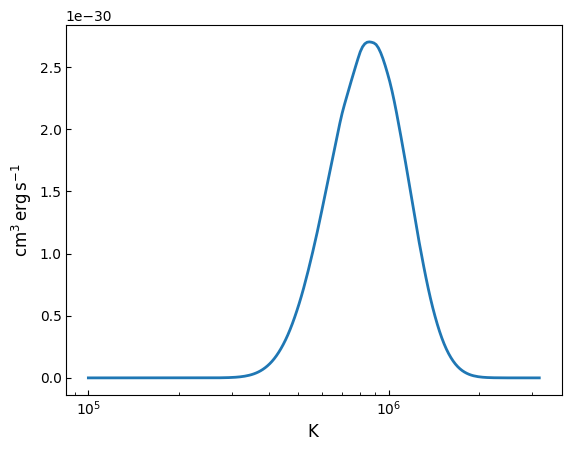

In [69]:
with quantity_support():
    plt.plot(fe9.temperature,goft.squeeze()[:,idx])
plt.xscale('log')

(1e-33, 3e-23)

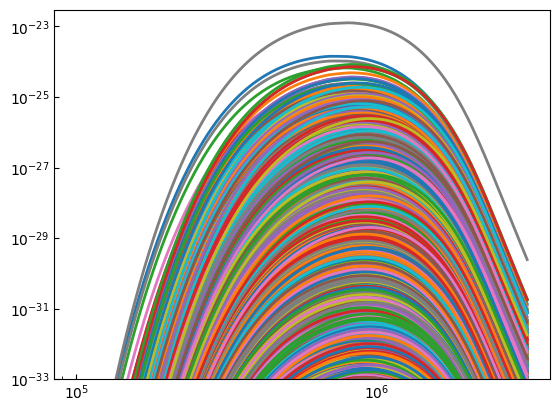

In [71]:
plt.plot(fe9.temperature, goft.squeeze());
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-33,3e-23)

In [72]:
level_pops = fe9.level_populations(1e10*u.cm**(-3),
                                   include_protons=False,
                                   include_level_resolved_rate_correction=False)

In [76]:
level_pops.shape

(200, 1, 915)

In [101]:
jdx = np.where(fe9.transitions.upper_level[idx] == fe9._elvlc['level'])

In [102]:
jdx

(array([424]),)

(1e-20, 1)

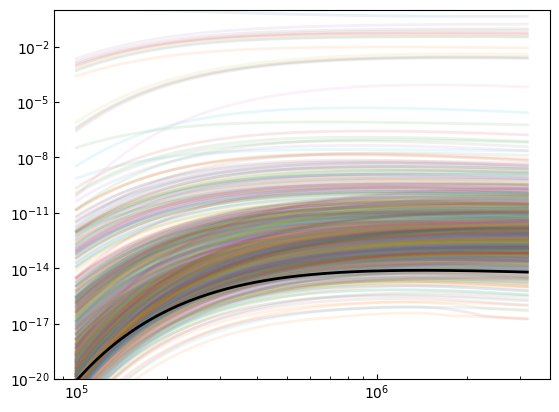

In [93]:
plt.plot(fe9.temperature, level_pops.squeeze(), alpha=0.1);
plt.plot(fe9.temperature, level_pops.squeeze()[:,jdx[0]], color='k')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-20,1)